## imports

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset as TorchSubset
from torchvision import transforms, utils
import torchvision.models.detection as detection


import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage import io, transform

import random
from collections import Counter
from PIL import Image
from tqdm import tqdm
import copy
import time

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()  

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# file path etc

import config
from config import root, root_micro
import importlib
importlib.reload(config)

<module 'config' from 'c:\\Users\\Marie\\Documents\\info m2 local\\DLCV\\projet\\git\\DL_project_marie_clara\\config.py'>

## Pre treatement

### class

In [5]:
class CROHMEDataset(Dataset):
    """
    Dataset pour les expressions complètes (PNG + LG).
    Chaque sample retourne :
        - image : Tensor CxHxW
        - target : dict contenant "boxes" et "labels"
    """

    def __init__(self, root, transform=None, meta_classes=True):
        """
        root : chemin du dossier contenant les PNG + LG
        transform : transform PyTorch (augmentations, ToTensor, Resize…)
        meta_classes : si True, map chaque label vers une méta-classe
        """
        self.root = root
        self.transform = transform
        self.meta_classes = meta_classes

        # liste des fichiers PNG pour lesquels le fichier .lg associé existe
        all_files = os.listdir(root)
        pngs = [f for f in all_files if f.endswith('.png')]
        pngs.sort()
        self.images = []
        for f in pngs:
            lg = f.replace('.png', '.lg')
            if lg in all_files:
                self.images.append(f)
            else:
                # avertir mais ne pas planter : on ignore les images sans annotation
                print(f"Warning: missing .lg for {f} -> skipping this image")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)

        lg_name = img_name.replace(".png", ".lg")
        lg_path = os.path.join(self.root, lg_name)

        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        boxes = []
        labels = []

        # If the .lg file is missing for some reason, return an example with empty targets
        if not os.path.exists(lg_path):
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            target = {"boxes": boxes, "labels": labels}
            if self.transform:
                image = self.transform(image)
            return image, target

        with open(lg_path, "r", encoding='utf-8', errors='ignore') as f:
            for line in f:
                parts = [p.strip() for p in line.strip().split(",") if p.strip() != ""]
                if len(parts) < 6:
                    parts = [p.strip() for p in line.strip().split() if p.strip() != ""]
                if len(parts) < 6:
                    continue

                label = parts[1]
                try:
                    last4 = parts[-4:]
                    vals = [float(v) for v in last4]
                except Exception:
                    continue

                # try possible orderings and keep the one that fits image bounds
                candidates = [
                    (vals[0], vals[1], vals[2], vals[3]),  # assume xmin,ymin,xmax,ymax
                    (vals[1], vals[0], vals[3], vals[2]),  # assume ymin,xmin,ymax,xmax (old)
                ]

                chosen = None
                for xmin, ymin, xmax, ymax in candidates:
                    if xmin < xmax and ymin < ymax and 0 <= xmin < xmax <= orig_w and 0 <= ymin < ymax <= orig_h:
                        chosen = (xmin, ymin, xmax, ymax)
                        break

                # if none valid, clamp first candidate and skip if degenerate
                if chosen is None:
                    xmin, ymin, xmax, ymax = candidates[0]
                    xmin = max(0.0, min(xmin, orig_w))
                    xmax = max(0.0, min(xmax, orig_w))
                    ymin = max(0.0, min(ymin, orig_h))
                    ymax = max(0.0, min(ymax, orig_h))
                    if xmax <= xmin or ymax <= ymin:
                        # skip invalid/degenerate box
                        continue
                    chosen = (xmin, ymin, xmax, ymax)

                xmin, ymin, xmax, ymax = chosen

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.map_label(label))

        # Convert to tensors; ensure correct shapes even when empty
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

    def map_label(self, label):
        raw = label.split("_")[0].strip()
        if raw.isalpha():
            return 0

        if raw.isdigit():
            return 1

        if raw in {"+", "-", "=", "/", "*", "×", "÷", "^"}:
            return 2
        return 3

    def raw_label_to_id(self, raw):
        if not hasattr(self, "raw_vocab"):
            self.raw_vocab = {}
        if raw not in self.raw_vocab:
            self.raw_vocab[raw] = len(self.raw_vocab)
        return self.raw_vocab[raw]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

### Dataset

#### Dataset

In [6]:
dataset = CROHMEDataset(
    root=root,
    transform=transforms.ToTensor(),
    meta_classes=True
)

image, target = dataset[0]
print("Image : ", image.size())
print("Target : ", target)

dataset_len = len(dataset)
train_len = int(0.8 * dataset_len)
val_len = int(0.1 * dataset_len)
test_len = dataset_len - train_len - val_len

train, val, test = torch.utils.data.random_split(
    dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
)
print(f"Dataset sizes -> total: {dataset_len}, train: {train_len}, val: {val_len}, test: {test_len}")

Image :  torch.Size([3, 119, 500])
Target :  {'boxes': tensor([[ 10.,  40.,  39., 108.],
        [270.,  46., 320.,  72.],
        [340.,  47., 371.,  71.],
        [467.,  10., 489.,  38.],
        [121.,  38., 166.,  63.],
        [226.,  21., 265.,  65.],
        [399.,  10., 452.,  76.]]), 'labels': tensor([0, 0, 2, 1, 2, 0, 0])}
Dataset sizes -> total: 9992, train: 7993, val: 999, test: 1000
Image :  torch.Size([3, 119, 500])
Target :  {'boxes': tensor([[ 10.,  40.,  39., 108.],
        [270.,  46., 320.,  72.],
        [340.,  47., 371.,  71.],
        [467.,  10., 489.,  38.],
        [121.,  38., 166.,  63.],
        [226.,  21., 265.,  65.],
        [399.,  10., 452.,  76.]]), 'labels': tensor([0, 0, 2, 1, 2, 0, 0])}
Dataset sizes -> total: 9992, train: 7993, val: 999, test: 1000


In [7]:
batch_size = 3
# Use the Subset objects created earlier by random_split: `train`, `val`, `test`.
# If `train` or `val` don't exist yet (cell not executed), compute splits here as a fallback.
try:
    train_subset = train
    val_subset = val
except NameError:
    dataset_len = len(dataset)
    # train_len = int(0.8 * dataset_len)
    # val_len = int(0.1 * dataset_len)
    # test_len = dataset_len - train_len - val_len
    train_len = 100
    val_len = 100
    test_len = 20
    train_subset, val_subset, _ = torch.utils.data.random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## fuctions for visualisation

In [8]:
def show_raw_boxes(dataset, idx=None):
    """
    Affiche les bounding boxes "brutes" et les labels pour un sample (ou un index aléatoire).
    """

    if idx is None:
        # choisir un index aléatoire dans le dataset/subset
        if isinstance(dataset, TorchSubset):
            n = len(dataset)
        else:
            n = len(dataset)
        idx = random.randrange(n)

    # gérer Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    _, target = base[real_idx]
    boxes = target.get("boxes", None)
    labels = target.get("labels", None)

    # Affichage
    print(f"dataset index (subset idx) = {idx}, real index = {real_idx}")
    print("boxes (raw):")
    if boxes is None:
        print(None)
    else:
        try:
            # si tensor -> list
            if hasattr(boxes, "tolist"):
                print(boxes.tolist())
            else:
                print(boxes)
        except Exception:
            print(repr(boxes))

    print("labels (raw):")
    if labels is None:
        print(None)
    else:
        try:
            if hasattr(labels, "tolist"):
                print(labels.tolist())
            else:
                print(labels)
        except Exception:
            print(repr(labels))

    return boxes, labels

In [9]:
def show_image(dataset, idx: int, debug: bool=False):
    """Debug: print sizes, raw boxes and scaled boxes; draw all boxes with indices."""
    
    # handle Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    sample_image, target = base[real_idx]
    # ensure tensor
    if not isinstance(sample_image, torch.Tensor):
        sample_image = transforms.ToTensor()(sample_image)

    img_name = base.images[real_idx]
    img_path = os.path.join(base.root, img_name)
    with Image.open(img_path) as pil:
        orig_w, orig_h = pil.size

    _, h, w = sample_image.shape
    if debug:
        print(f"real_idx={real_idx} orig_w,orig_h=({orig_w},{orig_h}) tensor_w,h=({w},{h})")

    boxes = target.get("boxes", torch.zeros((0,4)))
    labels = target.get("labels", None)
    if debug:
        print("raw boxes:", boxes if not hasattr(boxes, "tolist") else boxes.tolist())
    if labels is not None:
        if debug:
            print("raw labels:", labels.tolist() if hasattr(labels, "tolist") else labels)

    # Ensure tensor
    if isinstance(boxes, list):
        boxes = torch.tensor(boxes, dtype=torch.float32)
    boxes_scaled = boxes.clone()
    if boxes_scaled.numel() > 0:
        scale_x = w / orig_w if orig_w>0 else 1.0
        scale_y = h / orig_h if orig_h>0 else 1.0
        boxes_scaled[:, [0,2]] *= scale_x
        boxes_scaled[:, [1,3]] *= scale_y

    if debug:
        print("scaled boxes:", boxes_scaled.tolist() if hasattr(boxes_scaled, "tolist") else boxes_scaled)

    # clip to image and report which boxes become invalid/empty
    boxes_clipped = boxes_scaled.clone()
    if boxes_clipped.numel() > 0:
        boxes_clipped[:, 0] = boxes_clipped[:, 0].clamp(min=0, max=w)
        boxes_clipped[:, 2] = boxes_clipped[:, 2].clamp(min=0, max=w)
        boxes_clipped[:, 1] = boxes_clipped[:, 1].clamp(min=0, max=h)
        boxes_clipped[:, 3] = boxes_clipped[:, 3].clamp(min=0, max=h)
        areas = (boxes_clipped[:,2]-boxes_clipped[:,0]).clamp(min=0) * (boxes_clipped[:,3]-boxes_clipped[:,1]).clamp(min=0)
        if debug:
            for i, a in enumerate(areas.tolist()):
                print(f"box {i} area after clipping = {a:.1f}")

    # draw
    npimg = sample_image.numpy().transpose(1,2,0)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(npimg)
    cmap = plt.get_cmap("tab10")
    for i, box in enumerate(boxes_clipped if boxes_clipped.numel()>0 else torch.zeros((0,4))):
        xmin, ymin, xmax, ymax = [float(x) for x in box]
        color = cmap(i % 10)
        rect = mpl.patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-6, f"{i}", color=color, fontsize=10, weight="bold", backgroundcolor="white")
    ax.axis("off")
    plt.show()
    return {"orig_size": (orig_w, orig_h), "tensor_size": (w,h), "raw_boxes": boxes, "scaled": boxes_scaled, "clipped": boxes_clipped}


In [10]:
def accuracy_test(net,
                  testloader,
                  minibatchsize = 32,
                  nb_classes = 5,
                  classes = ['alpha', 'digit', 'operator', 'other', 'background'],
                  print_acc = False,
                  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")) :
    """Teste le réseau de neurones sur le dataset de test, puis calcule son accuracy globale et pour chaque classe"""
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Check the results for each class
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


            # garder pour la matrice
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if print_acc :
        print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * correct / total))
        for i in range(nb_classes):
            if class_total[i] > 0 :
                print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
                    classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
            else:
                print('No %5s sample' % (classes[i]))

    return correct, total, class_correct, class_total, all_preds, all_labels

def print_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.xlabel("Predictions")
    plt.ylabel("Ground Truth")
    plt.title("Confusion matrix")
    plt.show()

### Viz of examples

dataset index (subset idx) = 0, real index = 0
boxes (raw):
[[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
labels (raw):
[0, 0, 2, 1, 2, 0, 0]
real_idx=0 orig_w,orig_h=(500,119) tensor_w,h=(500,119)
raw boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
raw labels: [0, 0, 2, 1, 2, 0, 0]
scaled boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
box 0 area after clipping = 1972.0
box 1 area after clipping = 1300.0
box 2 area after clipping = 744.0
box 3 area after clipping = 616.0
box 4 area after clipping = 1125.0
box 5 area after clipping = 

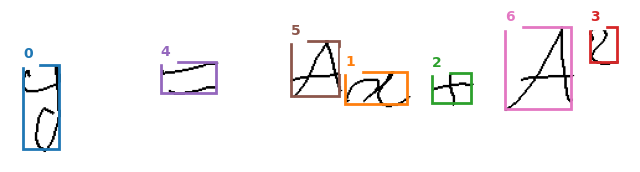

Test sur dataset[0]


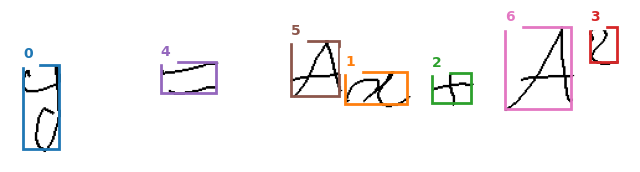

Test sur train_subset[0]


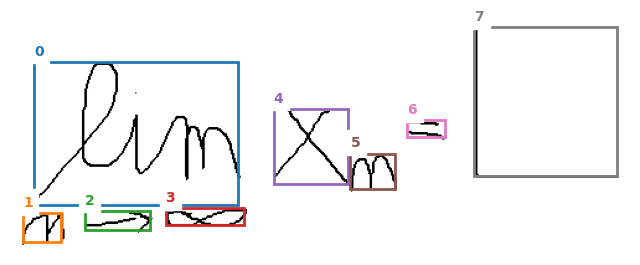

In [11]:
show_raw_boxes(dataset, 0)
show_image(dataset, 0, debug=True)

# Cellule de test pour show_image_with_boxes
try:
    print("Test sur dataset[0]")
    show_image(dataset, 0, debug=False)
except Exception as e:
    print("Erreur sur dataset:", e)

# Si vous utilisez un Subset (train_subset), tester aussi :
try:
    print("Test sur train_subset[0]")
    show_image(train_subset, 0, debug=False)
except Exception as e:
    print("Erreur sur train_subset:", e)


## Baseline: NetMLP

### data

In [30]:
class NetMLP(nn.Module):
    def __init__(self, hiddencells=100, out_classes=5):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32, hiddencells)
        self.fc2 = nn.Linear(hiddencells, out_classes)
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits for CrossEntropyLoss

# transform for MLP (32x32 grayscale)
mlp_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


In [31]:
# small dataset for quick test (use full dataset if desired)
dataset_mlp = CROHMEDataset(root=root, transform=mlp_transform, meta_classes=True)

# split
n = len(dataset_mlp)
train_n = int(0.8 * n)
val_n = int(0.1 * n)
test_n = n - train_n - val_n
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset_mlp, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

def collate_for_mlp(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)            # (B, C, H, W)
    labels = []
    for t in targets:
        labs = t.get("labels", None)
        if labs is None or len(labs) == 0:
            labels.append(0)
        else:
            v = labs[0]
            labels.append(int(v.item()) if torch.is_tensor(v) else int(v))
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_for_mlp, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)



### training loop

In [32]:
def fullTraining(net,
                 trainloader,
                 validationloader,
                 validationset,
                 optimizer,
                 criterion = nn.CrossEntropyLoss(),
                 minibatchsize = 32,
                 num_epochs = 5,
                 print_every = 10,
                 print_epoch = True,
                 savename = ''):
    """Entraîne le réseau de neurones en entrée sur les datasets d'entraînement et de validation"""

    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = float('inf')
    best_nb_sample = 0
    running_loss = 0.0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model only when loss is better
                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_model = copy.deepcopy(net)
        if print_epoch :
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

    # save the best model
    if savename != '':
        torch.save(best_model.state_dict(), f"./best_model_{savename}.nn")

    # learning curves
    fig, ax = plt.subplots()
    ax.set_xlabel('epoch')
    ax.set_ylabel('val (blue)/ train (red) LOSS')
    ax.set_title('Digit classifier')
    ax.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b', nb_sample_array.tolist(), train_err_array.tolist(), 'r')

    # trained network
    return best_model, fig


----- Initialisation of the neural network -----
----- Training of the neural network -----
Epoch 1 of 25 took 7.123s
Epoch 1 of 25 took 7.123s
Epoch 2 batch   250 
Train loss : 0.033
Epoch 2 batch   250 
Train loss : 0.033
Validation loss mean : 0.034
Epoch 2 of 25 took 7.957s
Validation loss mean : 0.034
Epoch 2 of 25 took 7.957s
Epoch 3 of 25 took 6.948s
Epoch 3 of 25 took 6.948s
Epoch 4 batch   250 
Train loss : 0.033
Epoch 4 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 4 of 25 took 7.805s
Validation loss mean : 0.033
Epoch 4 of 25 took 7.805s
Epoch 5 of 25 took 6.961s
Epoch 5 of 25 took 6.961s
Epoch 6 batch   250 
Train loss : 0.033
Epoch 6 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 6 of 25 took 7.858s
Validation loss mean : 0.033
Epoch 6 of 25 took 7.858s
Epoch 7 of 25 took 6.981s
Epoch 7 of 25 took 6.981s
Epoch 8 batch   250 
Train loss : 0.033
Epoch 8 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 8 of 25 took 7.

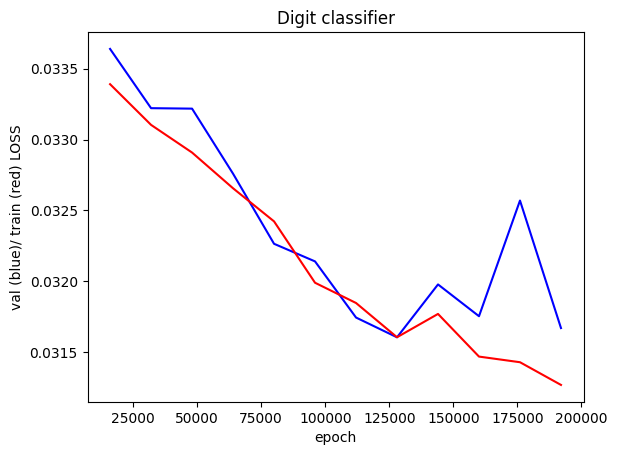

----- Evaluation of the neural network on the test set -----
Accuracy of the network on the test images: 57.20 %
Accuracy of alpha : 29.64 % (91/307)
Accuracy of digit : 0.00 % (0/137)
Accuracy of operator : 0.00 % (0/24)
Accuracy of other : 90.41 % (481/532)
No background sample
Accuracy of the network on the test images: 57.20 %
Accuracy of alpha : 29.64 % (91/307)
Accuracy of digit : 0.00 % (0/137)
Accuracy of operator : 0.00 % (0/24)
Accuracy of other : 90.41 % (481/532)
No background sample


In [34]:
##### Neural network #####

print("----- Initialisation of the neural network -----")
net = NetMLP(hiddencells=100, out_classes=5)  # 4 meta-classes
net.to(device) # move it to GPU or CPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.01)




##### Training #####

print("----- Training of the neural network -----")
best_model, fig = fullTraining(
    net = net,
    trainloader = train_loader,
    validationloader = val_loader,
    validationset = val_ds,
    optimizer = optimizer,
    criterion = criterion,
    minibatchsize = batch_size,
    num_epochs = 25,
    print_every = 500,
    print_epoch = True,
    savename = 'mlp_crohme')

display(fig)
plt.close(fig)




##### Test of the trained neural network #####

print("----- Evaluation of the neural network on the test set -----")
correct, total, class_correct, class_total, all_preds, all_labels = accuracy_test(
    net,
    test_loader,
    minibatchsize = batch_size,
    print_acc = True,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))




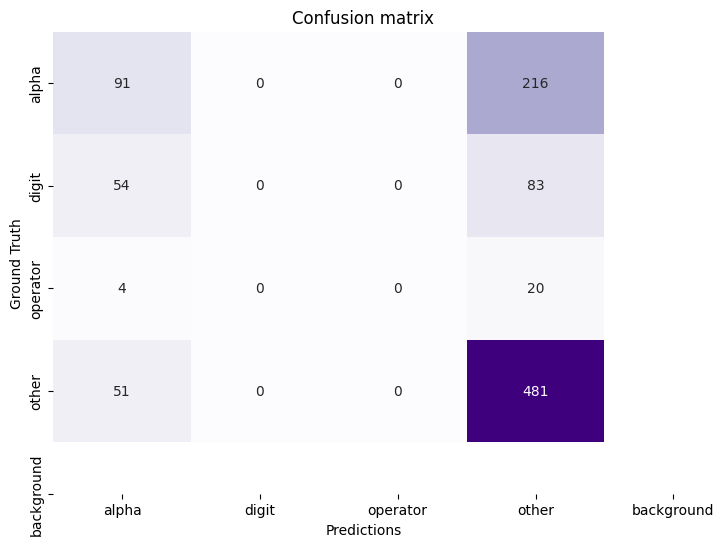

In [35]:
print_matrix(all_labels, all_preds, classes=['alpha', 'digit', 'operator', 'other', 'background'])

## Faster RCNN from previous lab: fasterrcnn_resnet50_fpn

### training loops

In [ ]:
# Hyperparameters
num_epochs = 3
learning_rate =0.0008
batch_size = 3
val_size = 10

val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])
train_loss_classifier_array = np.array([])
train_loss_objectness_array = np.array([])

patience =5
epochs_without_improvement = 0

try:
    train_subset = train
    val_subset = val
except NameError:
    dataset_len = len(dataset)
    train_len = int(0.8 * dataset_len)
    val_len = int(0.1 * dataset_len)
    test_len = dataset_len - train_len - val_len
    train_subset, val_subset, _ = torch.utils.data.random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load a pretrained Faster R-CNN model
model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Set the requires_grad attribute of all the backbone parameters to False
for param in model.backbone.parameters():
    param.requires_grad = False
print("Backbone frozen. Only the RPN and heads will be trained.")

# Modify the model for the number of classes
num_classes = 5  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# Function for validation
def validate(model, val_loader):
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    return val_loss / len(val_loader)

# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_loss_classifier = 0.0
    epoch_loss_objectness = 0.0
    model.train()  # Set the model to training mode
    nb_used_sample = 0 # Initialize the number of samples used in this epoch

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move images and targets to the device (GPU or CPU)
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        # Use .get to avoid KeyError if a particular loss term is missing
        epoch_loss_classifier += loss_dict.get('loss_classifier', torch.tensor(0.0)).item()
        epoch_loss_objectness += loss_dict.get('loss_objectness', torch.tensor(0.0)).item()
        nb_used_sample += len(images)

    # Calculate average training loss for the epoch
    train_err = epoch_loss / len(train_loader)
    train_loss_classifier = epoch_loss_classifier / len(train_loader) if len(train_loader) > 0 else 0.0
    train_loss_objectness = epoch_loss_objectness / len(train_loader) if len(train_loader) > 0 else 0.0

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_err:.4f}, Classifier Loss: {train_loss_classifier:.4f}, Objectness Loss: {train_loss_objectness:.4f}")

    # Validate after each epoch
    val_loss = validate(model, val_loader)
    print(f"Validation Loss: {val_loss:.4f}")
    train_err_array = np.append(train_err_array, train_err)
    val_err_array = np.append(val_err_array, val_loss)
    nb_sample_array = np.append(nb_sample_array, nb_used_sample)
    train_loss_classifier_array = np.append(train_loss_classifier_array, train_loss_classifier)
    train_loss_objectness_array = np.append(train_loss_objectness_array, train_loss_objectness)

    # Save the model weights if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'faster_rcnn_voc_best.pth')
        print(f"Model weights saved. New best validation loss: {best_val_loss:.4f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping after {patience} epochs without improvement.")
        break

# Final message
print("Training complete.")

Backbone frozen. Only the RPN and heads will be trained.


Epoch 1/3: 100%|██████████| 56/56 [03:33<00:00,  3.80s/it]



Epoch [1/3], Loss: 1.6500, Classifier Loss: 0.4676, Objectness Loss: 0.4545
Validation Loss: 0.8750
Validation Loss: 0.8750
Model weights saved. New best validation loss: 0.8750
Model weights saved. New best validation loss: 0.8750


Epoch 2/3: 100%|██████████| 56/56 [03:43<00:00,  3.99s/it]



Epoch [2/3], Loss: 1.0643, Classifier Loss: 0.2817, Objectness Loss: 0.0997
Validation Loss: 0.8397
Validation Loss: 0.8397
Model weights saved. New best validation loss: 0.8397
Model weights saved. New best validation loss: 0.8397


Epoch 3/3: 100%|██████████| 56/56 [03:33<00:00,  3.81s/it]



Epoch [3/3], Loss: 0.9854, Classifier Loss: 0.2533, Objectness Loss: 0.0913
Validation Loss: 0.7962
Validation Loss: 0.7962
Model weights saved. New best validation loss: 0.7962
Training complete.
Model weights saved. New best validation loss: 0.7962
Training complete.


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# Wrapper converting CROHMEDataset outputs to the format expected by torchvision detection
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, base_ds):
        self.ds = base_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        # Support Subset as well as base dataset
        if isinstance(self.ds, torch.utils.data.Subset):
            base = self.ds.dataset
            real_idx = self.ds.indices[idx]
            img, target = base[real_idx]
        else:
            img, target = self.ds[idx]

        boxes = target.get('boxes', torch.zeros((0,4), dtype=torch.float32))
        labels = target.get('labels', torch.zeros((0,), dtype=torch.int64))
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels, dtype=torch.int64)
        # torchvision detection expects labels starting at 1 (0 is background)
        if labels.numel() > 0:
            labels = labels.clone() + 1
        return img, {'boxes': boxes, 'labels': labels}

# collate fn for detection (returns lists)
def det_collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Build detection datasets / loaders from existing train_subset / val_subset
# Note: train_subset, val_subset must be defined earlier in the notebook (Subsets from random_split)
det_train_ds = DetectionDataset(train_subset)
det_val_ds = DetectionDataset(val_subset)

train_loader_det = DataLoader(det_train_ds, batch_size=4, shuffle=True, collate_fn=det_collate_fn, num_workers=0)
val_loader_det   = DataLoader(det_val_ds,   batch_size=4, shuffle=False, collate_fn=det_collate_fn, num_workers=0)

# Number of classes: 4 meta-classes + background
num_detection_classes = 5

# Create a Faster R-CNN model with a ResNet50 FPN backbone
model_det = detection.fasterrcnn_resnet50_fpn(pretrained=True)
# replace the head
in_features = model_det.roi_heads.box_predictor.cls_score.in_features
model_det.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_detection_classes)
model_det.to(device)

# Optimizer
params = [p for p in model_det.parameters() if p.requires_grad]
optimizer_det = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Simple training loop (few epochs) - prints loss dict and a small validation summary
num_epochs_det = 3
for epoch in range(num_epochs_det):
    model_det.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader_det):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model_det(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer_det.zero_grad()
        losses.backward()
        optimizer_det.step()
        running_loss += losses.item()
        if i % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs_det}  Iter {i}  loss {losses.item():.4f}  loss_dict_keys={list(loss_dict.keys())}")
    print(f"Epoch {epoch+1} train mean loss: {running_loss / (i+1):.4f}")

    # quick val - forward on a couple batches, show number of boxes predicted
    model_det.eval()
    with torch.no_grad():
        total_preds = 0
        examples = 0
        for j, (images, targets) in enumerate(val_loader_det):
            images = [img.to(device) for img in images]
            outputs = model_det(images)
            # each output is a dict with keys 'boxes','labels','scores'
            for out in outputs:
                total_preds += len(out.get('boxes', []))
                examples += 1
            if j >= 4:  # only a few batches
                break
        if examples > 0:
            print(f"Validation: mean predicted boxes per im age: {total_preds / examples:.2f} (over {examples} images)")

# Save weights
torch.save(model_det.state_dict(), 'fasterrcnn_crohme.pth')
print('Saved detector to fasterrcnn_crohme.pth')


### pred functions

In [39]:
def get_predictions_and_ground_truths(model, val_loader, device, score_thresh=0.05):
    """Return two lists suitable for mean_average_precision() usage:
       - pred_boxes: list of [img_idx, class, score, x1, y1, x2, y2]
       - true_boxes: list of [img_idx, class, 1.0, x1, y1, x2, y2]

    The function is robust to different val_loader collate outputs (lists/tuples/tensors).
    Labels are normalized to 0-based classes (mean_average_precision expects classes in 0..num_classes-1).
    """
    model.eval()
    pred_boxes = []
    true_boxes = []
    img_global_idx = 0

    with torch.no_grad():
        for batch in val_loader:
            # Expecting batch = (images, targets) where images is list/tuple or tensor, targets is list/tuple of dicts
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                images, targets = batch
            else:
                # fallback: if dataloader yields only images, we can't get GT boxes
                images = batch
                targets = [None] * (len(images) if hasattr(images, '__len__') else 1)

            # normalize images to list
            if torch.is_tensor(images):
                images_list = [img.to(device) for img in images]
            else:
                # images may be tuple/list of tensors already
                images_list = [img.to(device) for img in images]

            # forward
            outputs = model(images_list)

            # outputs is a list with length == len(images_list)
            for b_idx, output in enumerate(outputs):
                global_idx = img_global_idx + b_idx

                pred_boxes_list = output.get('boxes', torch.empty((0,4))).cpu().numpy()
                pred_scores_list = output.get('scores', torch.empty((0,))).cpu().numpy()
                pred_labels_list = output.get('labels', torch.empty((0,))).cpu().numpy()

                # append predictions (convert labels to 0-based for mAP)
                for j in range(len(pred_boxes_list)):
                    score = float(pred_scores_list[j])
                    if score < score_thresh:
                        continue
                    lbl = int(pred_labels_list[j]) - 1 if len(pred_labels_list) > 0 else 0
                    x1, y1, x2, y2 = [float(x) for x in pred_boxes_list[j]]
                    pred_boxes.append([global_idx, lbl, score, x1, y1, x2, y2])

                # ground-truth handling
                tgt = None
                if isinstance(targets, (list, tuple)) and b_idx < len(targets):
                    tgt = targets[b_idx]
                else:
                    tgt = targets

                if isinstance(tgt, dict):
                    try:
                        gt_boxes_arr = tgt.get('boxes', torch.empty((0,4))).cpu().numpy()
                        gt_labels_arr = tgt.get('labels', torch.empty((0,))).cpu().numpy()
                    except Exception:
                        # defensive: if shapes unexpected, skip
                        gt_boxes_arr = np.empty((0,4))
                        gt_labels_arr = np.empty((0,))

                    for k in range(len(gt_boxes_arr)):
                        lbl_gt = int(gt_labels_arr[k]) - 1 if len(gt_labels_arr) > 0 else 0
                        x1, y1, x2, y2 = [float(x) for x in gt_boxes_arr[k]]
                        true_boxes.append([global_idx, lbl_gt, 1.0, x1, y1, x2, y2])

                # otherwise no ground-truth boxes (skip)

            img_global_idx += len(outputs)

    return pred_boxes, true_boxes


In [ ]:
# Functions from https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def compute_map(pred_boxes, true_boxes, num_classes, iou_threshold=0.5, box_format='corners'):
    """Clean inputs, print diagnostics and compute mAP using mean_average_precision safely.
    Returns (mAP, details_dict)
    """
    # Ensure lists
    preds = list(pred_boxes) if pred_boxes is not None else []
    gts = list(true_boxes) if true_boxes is not None else []

    print(f"Raw counts -> preds: {len(preds)}, gts: {len(gts)}")
    if len(preds) == 0:
        print("Warning: no predictions were produced (pred_boxes is empty). mAP will be 0.")
    if len(gts) == 0:
        print("Warning: no ground-truth boxes provided (true_boxes is empty). mAP undefined; returning 0.")

    # Normalize formats: allow true to be [img, class, score?, x1,y1,x2,y2] or [img,class,x1,y1,x2,y2]
    def normalize_true(t):
        t = list(t)
        if len(t) == 7:
            # [img, class, score, x1..]
            return [t[0], int(t[1]), float(t[2]), float(t[3]), float(t[4]), float(t[5]), float(t[6])]
        elif len(t) == 6:
            # insert dummy score=1.0 to match expected indexing in some helpers
            return [t[0], int(t[1]), 1.0, float(t[2]), float(t[3]), float(t[4]), float(t[5])]
        else:
            raise ValueError(f"Unexpected true_box format length={len(t)}: {t}")

    def normalize_pred(p):
        p = list(p)
        if len(p) == 7:
            return [int(p[0]), int(p[1]), float(p[2]), float(p[3]), float(p[4]), float(p[5]), float(p[6])]
        else:
            raise ValueError(f"Unexpected pred_box format length={len(p)}: {p}")

    # Filter invalid classes and normalize
    cleaned_preds = []
    for p in preds:
        try:
            npred = normalize_pred(p)
        except Exception as e:
            print('Skipping pred with unexpected format:', p, '->', e)
            continue
        cls = npred[1]
        if cls < 0 or cls >= num_classes:
            print(f"Skipping pred with out-of-range class {cls}")
            continue
        cleaned_preds.append(npred)

    cleaned_gts = []
    for g in gts:
        try:
            ng = normalize_true(g)
        except Exception as e:
            print('Skipping gt with unexpected format:', g, '->', e)
            continue
        cls = int(ng[1])
        if cls < 0 or cls >= num_classes:
            print(f"Skipping gt with out-of-range class {cls}")
            continue
        cleaned_gts.append(ng)

    print(f"Cleaned counts -> preds: {len(cleaned_preds)}, gts: {len(cleaned_gts)}")
    print('Classes in preds:', sorted(set([p[1] for p in cleaned_preds])))
    print('Classes in gts:', sorted(set([g[1] for g in cleaned_gts])))

    # If no ground-truth classes, return 0
    if len(cleaned_gts) == 0:
        return 0.0, {'cleaned_preds': cleaned_preds, 'cleaned_gts': cleaned_gts}

    # Now compute mAP with existing mean_average_precision (defensive)
    try:
        mAP = mean_average_precision(cleaned_preds, cleaned_gts, iou_threshold=iou_threshold, box_format=box_format, num_classes=num_classes)
    except ZeroDivisionError:
        print('mean_average_precision raised ZeroDivisionError (no classes with GT). Returning 0.0')
        mAP = 0.0
    except Exception as e:
        print('mean_average_precision raised an error:', e)
        # As fallback, return 0.0
        mAP = 0.0

    return float(mAP), {'cleaned_preds': cleaned_preds, 'cleaned_gts': cleaned_gts}


### pred

In [ ]:
pred_boxes, true_boxes = get_predictions_and_ground_truths(model, val_loader, device, score_thresh=0.05)
mAP, details = compute_map(pred_boxes, true_boxes, num_classes=num_classes, iou_threshold=0.5, box_format='corners')
print("map =", mAP)

Raw counts -> preds: 8900, gts: 974
Cleaned counts -> preds: 8900, gts: 974
Classes in preds: [1, 2, 3]
Classes in gts: [0, 1, 2, 3]
map = 0.21963320672512054
map = 0.21963320672512054


Evaluation over 21 images (score_thresh= 0.5 , iou_thresh= 0.5 )
Class 1: TP=112 FP=30 FN=4  Precision=0.789 Recall=0.966
Class 2: TP=27 FP=7 FN=9  Precision=0.794 Recall=0.750
Class 3: TP=41 FP=5 FN=2  Precision=0.891 Recall=0.953
Class 4: TP=32 FP=22 FN=14  Precision=0.593 Recall=0.696
Overall: TP=212 FP=64 FN=29  Precision=0.768 Recall=0.880


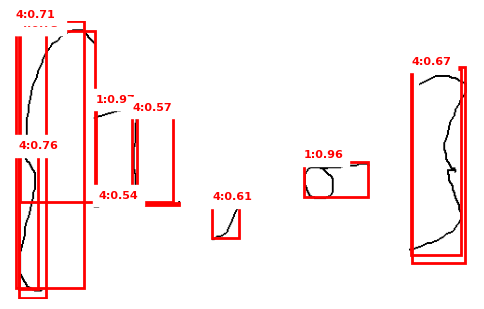

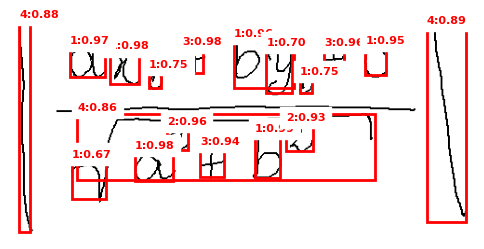

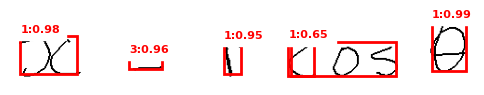

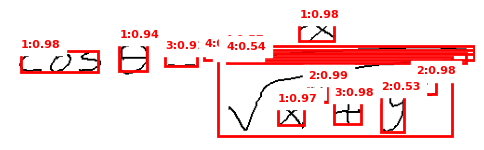

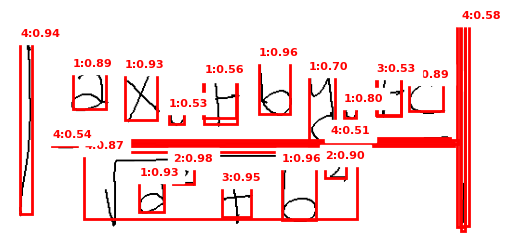

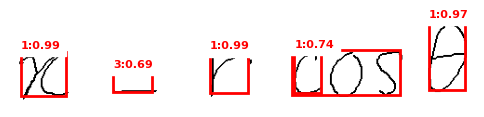

In [ ]:
import math
import matplotlib.patches as patches

detection_model = globals().get('model_det', globals().get('model', None))
if detection_model is None:
    print('No detection model found in the workspace (model_det or model). Aborting evaluation.')
else:
    detection_model.eval()

    def iou_numpy(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interW = max(0.0, xB - xA)
        interH = max(0.0, yB - yA)
        interArea = interW * interH
        boxAArea = max(0.0, boxA[2]-boxA[0]) * max(0.0, boxA[3]-boxA[1])
        boxBArea = max(0.0, boxB[2]-boxB[0]) * max(0.0, boxB[3]-boxB[1])
        union = boxAArea + boxBArea - interArea
        if union <= 0:
            return 0.0
        return interArea / union

    # prepare validation loader if missing
    if 'val_loader_det' in globals():
        vd_loader = val_loader_det
    else:
        try:
            det_val_ds = DetectionDataset(val_subset)
            vd_loader = DataLoader(det_val_ds, batch_size=4, shuffle=False, collate_fn=det_collate_fn, num_workers=0)
        except Exception as e:
            print('Could not build val_loader_det automatically:', e)
            vd_loader = None

    if vd_loader is None:
        print('No validation loader available. Stopping.')
    else:
        # metric accumulators
        num_classes = globals().get('num_detection_classes', 5)
        # index 0 reserved for background; classes are 1..num_classes-1
        TP = [0] * num_classes
        FP = [0] * num_classes
        FN = [0] * num_classes

        iou_thresh = 0.5
        score_thresh = 0.5
        max_images = 500  # limit for evaluation speed
        seen_images = 0

        with torch.no_grad():
            for images, targets in vd_loader:
                images_device = [img.to(device) for img in images]
                outputs = detection_model(images_device)
                # move to cpu for numpy ops
                for b_idx in range(len(outputs)):
                    out = outputs[b_idx]
                    pred_boxes = out.get('boxes', torch.zeros((0,4))).cpu().numpy()
                    pred_labels = out.get('labels', torch.zeros((0,))).cpu().numpy()
                    pred_scores = out.get('scores', torch.zeros((0,))).cpu().numpy()

                    gt = targets[b_idx]
                    gt_boxes = gt.get('boxes', torch.zeros((0,4))).cpu().numpy()
                    gt_labels = gt.get('labels', torch.zeros((0,))).cpu().numpy()

                    # Align label ranges: if gt labels start at 0 (0..K-1), shift to 1..K
                    if len(gt_labels) > 0 and gt_labels.min() == 0:
                        gt_labels = gt_labels + 1

                    # filter preds by score
                    keep = pred_scores >= score_thresh
                    pred_boxes = pred_boxes[keep]
                    pred_labels = pred_labels[keep]
                    pred_scores = pred_scores[keep]

                    # for each class do greedy matching
                    for cls in range(1, num_classes):
                        preds_idx = [i for i, l in enumerate(pred_labels) if int(l) == cls]
                        gt_idx = [i for i, l in enumerate(gt_labels) if int(l) == cls]

                        matched_gt = [False] * len(gt_idx)

                        # sort preds by score desc
                        preds_sorted = sorted(preds_idx, key=lambda k: -pred_scores[k])
                        for p in preds_sorted:
                            pbox = pred_boxes[p]
                            best_iou = 0.0
                            best_g = -1
                            for gi_i, gi in enumerate(gt_idx):
                                if matched_gt[gi_i]:
                                    continue
                                gbox = gt_boxes[gi]
                                iouv = iou_numpy(pbox, gbox)
                                if iouv > best_iou:
                                    best_iou = iouv
                                    best_g = gi_i
                            if best_iou >= iou_thresh and best_g >= 0:
                                TP[cls] += 1
                                matched_gt[best_g] = True
                            else:
                                FP[cls] += 1

                        # remaining unmatched gts are false negatives
                        FN[cls] += sum(1 for m in matched_gt if not m)

                    seen_images += 1
                    if seen_images >= max_images:
                        break
                if seen_images >= max_images:
                    break

        # compute precision/recall
        print('Evaluation over', seen_images, 'images (score_thresh=', score_thresh, ', iou_thresh=', iou_thresh, ')')
        for cls in range(1, num_classes):
            tp = TP[cls]
            fp = FP[cls]
            fn = FN[cls]
            prec = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
            rec = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
            print(f'Class {cls}: TP={tp} FP={fp} FN={fn}  Precision={prec:.3f} Recall={rec:.3f}')

        total_tp = sum(TP)
        total_fp = sum(FP)
        total_fn = sum(FN)
        overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else float('nan')
        overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else float('nan')
        print(f'Overall: TP={total_tp} FP={total_fp} FN={total_fn}  Precision={overall_prec:.3f} Recall={overall_rec:.3f}')

        # Visualize a few examples with predictions overlaid
        def visualize_prediction_on_image_tensor(img_tensor, pred_boxes, pred_scores, pred_labels, score_th=0.5):
            npimg = img_tensor.cpu().numpy().transpose(1,2,0)
            fig, ax = plt.subplots(1, figsize=(6,6))
            ax.imshow(npimg)
            for i, box in enumerate(pred_boxes):
                score = float(pred_scores[i])
                label = int(pred_labels[i])
                if score < score_th:
                    continue
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin-4, f'{label}:{score:.2f}', color='r', fontsize=8, weight='bold', backgroundcolor='white')
            ax.axis('off')
            plt.show()

        # pick some random examples from validation dataset
        import random
        n_show = 6
        indices = list(range(len(det_val_ds))) if 'det_val_ds' in globals() else list(range(len(val_subset)))
        if len(indices) == 0:
            print('No images to visualize')
        else:
            sel = random.sample(indices, min(n_show, len(indices)))
            for s in sel:
                # get image tensor and gt via dataset/subset access
                if 'det_val_ds' in globals():
                    img_tensor, tgt = det_val_ds[s]
                else:
                    base = val_subset.dataset if isinstance(val_subset, torch.utils.data.Subset) else val_subset
                    real_idx = val_subset.indices[s] if isinstance(val_subset, torch.utils.data.Subset) else s
                    img_tensor, tgt = base[real_idx]

                detection_model.to(device)
                detection_model.eval()
                with torch.no_grad():
                    inp = [img_tensor.to(device)]
                    out = detection_model(inp)[0]
                pboxes = out.get('boxes', torch.zeros((0,4))).cpu().numpy()
                plabels = out.get('labels', torch.zeros((0,))).cpu().numpy()
                pscores = out.get('scores', torch.zeros((0,))).cpu().numpy()
                visualize_prediction_on_image_tensor(img_tensor, pboxes, pscores, plabels, score_th=score_thresh)

